In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import sklearn as sk

In [ ]:
TICKER = 'SPY'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

SHIFT = 5
RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30

# what subsetion of that data are you interested in
LOOKBACK = 100

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

# define the target variable (also called dependent variable, or y)
def add_target(df, shift=SHIFT):

    # what is the close price SHIFT days from now?
    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    # what is the change in close price SHIFT days from now?
    df['Target'] = df[f'Close + {shift}'] - df['Close']

    return df

def add_RSI(df, length=RSI_LENGTH):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')

    return df.dropna()

def generate_regression_output(df, x='RSI', y='Target'):

    subset = df[[x, y]].dropna()

    # reshape for sklearn
    X = subset[[x]].values # 2d
    y = subset[y].values # 1d

    model = sk.linear_model.LinearRegression()
    model.fit(X, y)

    # use the regression model to "predict" the target variable
    y_pred = model.predict(X)

    # what is the relationship between features and target?
    r2 = sk.metrics.r2_score(y, y_pred)

    # coef, intercept, r2... mse later on
    print(f"Coefficient: {model.coef}")
    print(f"Intercept: {model.intercept}")

    return

def main():
    df = get_data()
    df = add_target(df)
    df = add_RSI(df)

    return df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Close + 5,Target,RSI
8125,564.340027,567.500000,562.760010,566.479980,37603400,594.200012,29.859985,87.201428
8126,582.989990,583.000000,577.039978,581.469971,78993600,594.849976,11.859985,88.125861
8127,586.840027,589.080017,582.840027,583.409973,67947200,592.849976,6.009949,87.380068
8128,587.590027,588.979980,585.539978,587.809998,66283500,582.859985,-4.730042,85.101285
8129,590.460022,590.969971,585.099976,585.559998,71268100,583.090027,-7.369995,84.819878
8130,594.200012,594.500000,589.280029,591.250000,76052100,579.109985,-15.090027,85.702537
8131,594.849976,595.539978,588.099976,588.099976,68168500,591.150024,-3.699951,85.006047
8132,592.849976,594.049988,589.599976,593.090027,60614500,587.729980,-5.119995,82.101566
8133,582.859985,592.580017,581.820007,588.440002,95197700,590.049988,7.190002,68.553189
8134,583.090027,586.619995,581.409973,582.659973,70860400,589.390015,6.299988,64.158160


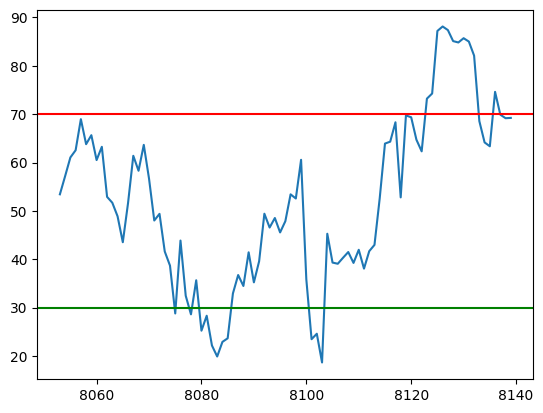

In [38]:
df = main()
df.tail(10)